In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import warnings
warnings.filterwarnings("ignore")


# Inladen van de primaire dataset:

In [2]:
df = pd.read_csv('onlinefraud.csv')
df.sample(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3654484,275,CASH_OUT,51673.06,C1409429086,0.00,0.00,C1587002871,584488.26,636161.33,0,0
1333655,137,PAYMENT,21662.67,C110048430,51256.00,29593.33,M1712942644,0.00,0.00,0,0
2241561,186,DEBIT,2527.38,C1792244314,17927.42,15400.04,C1148626322,39802.14,42329.52,0,0
3717586,278,CASH_OUT,240763.28,C625811450,14674.00,0.00,C1971978395,0.00,240763.28,0,0
3738024,278,TRANSFER,985331.17,C217176996,5642.00,0.00,C1585452577,2868453.68,3853784.85,0,0
100749,10,CASH_OUT,158341.11,C1354258053,199846.00,41504.89,C690195469,0.00,41462.83,0,0
2112769,183,CASH_OUT,147790.39,C312028838,206446.00,58655.61,C367711265,145332.76,293123.15,0,0
3724733,278,PAYMENT,5959.66,C1867862876,11000.00,5040.34,M1690520181,0.00,0.00,0,0
1775128,162,PAYMENT,21511.76,C1936737953,252371.78,230860.03,M2011184509,0.00,0.00,0,0
870057,42,CASH_IN,215532.02,C372452190,48961.00,264493.02,C1889295780,0.00,0.00,0,0


# Verwijderen van onbelangrijke features

In [3]:
df = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

In [4]:
print(df.isnull().sum())


type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["type"] = encoder.fit_transform(df["type"])



# Matrix voor de correlatie

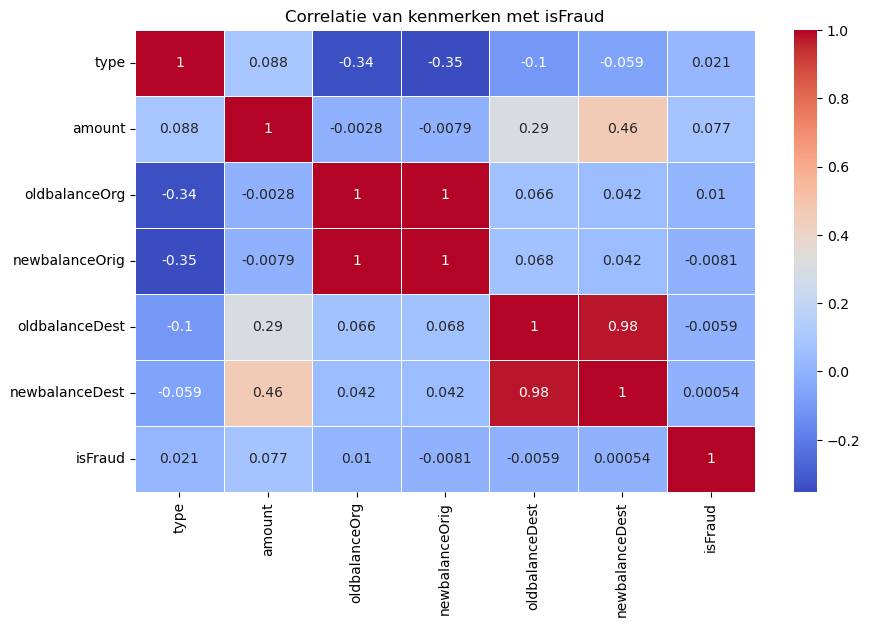

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlatie van kenmerken met isFraud")
plt.show()


# Bepalen van de errorbalanceorig en errorbalancedest
### Bereken balansafwijkingen voor verzender en ontvanger. Deze waarden zouden nul moeten zijn als het saldo correct wordt bijgewerkt na de transactie. Niet-nul waarden kunnen wijzen op frauduleuze transacties.

In [7]:
df['errorBalanceOrig'] = df.newbalanceOrig + df.amount - df.oldbalanceOrg
df['errorBalanceDest'] = df.oldbalanceDest + df.amount - df.newbalanceDest

# Het splitten en trainen van de data

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["isFraud"])  # Features
y = df["isFraud"]  # Goal feature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Trainen met het model: Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.36      0.79      0.50      1643

    accuracy                           1.00   1272524
   macro avg       0.68      0.89      0.75   1272524
weighted avg       1.00      1.00      1.00   1272524



# Trainen met het model: Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=40, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      0.73      0.84      1643

    accuracy                           1.00   1272524
   macro avg       1.00      0.86      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



# Toon de belangrijkste features

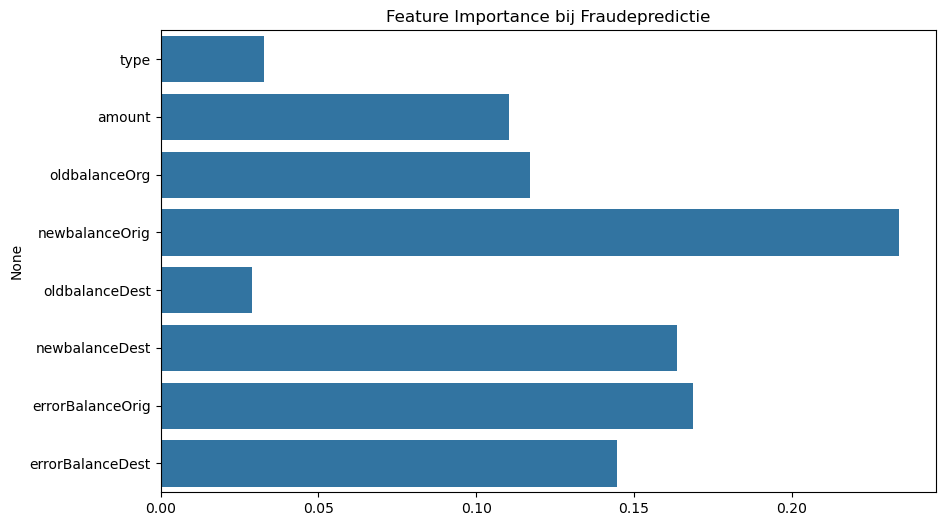

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances van Random Forest
importances = model.feature_importances_
feature_names = X.columns

# Visualiseren
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance bij Fraudepredictie")
plt.show()


# Trainen met het model: XGBoost

In [12]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",  # Suitable for fraud detection (binary classification)
    eval_metric="logloss",  
    use_label_encoder=False,  
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Get fraud probability


# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report (Precision, Recall, F1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9999
Confusion Matrix:
 [[1270773     108]
 [     76    1567]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.94      0.95      0.94      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.98      0.97   1272524
weighted avg       1.00      1.00      1.00   1272524



# Toon de belangrijkste features 

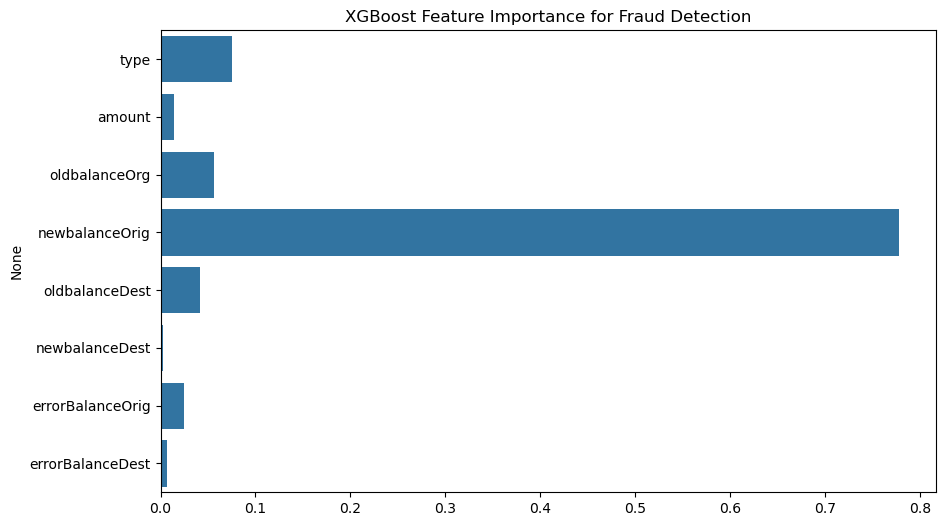

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Create a feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=X_train.columns)
plt.title("XGBoost Feature Importance for Fraud Detection")
plt.show()


# Cross validatie met XGBoost

In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
warnings.filterwarnings("ignore")

Cross-Validation Accuracy: 0.9998 ± 0.0000


# TREE_METHOD verwijderen zodat er CPU gebruikt wordt in plaats van GPU 

In [15]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    tree_method='gpu_hist',  # Enable GPU
    random_state=42
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [3, 5],  # Depth of trees (smaller = less overfitting)
    'learning_rate': [0.01, 0.1],  # Step size (smaller = more generalization)
    'subsample': [0.7, 0.8],  # Fraction of data used per tree
    'colsample_bytree': [0.7, 0.8],  # Fraction of features used per tree
    'reg_lambda': [0, 1],  # L2 Regularization (higher = less overfitting)
    'reg_alpha': [0, 1]  # L1 Regularization (higher = feature selection)
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)

# Fit on training data
grid_search.fit(X_train, y_train)
# Print best hyperparameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)



Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.9998554054775791


# Train XGboost met de beste parameters

In [16]:
# Train XGBoost with best parameters
best_xgb = grid_search.best_estimator_

# Predict on test set
y_pred = best_xgb.predict(X_test)

# Print accuracy
from sklearn.metrics import accuracy_score
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Test Accuracy: 0.9999


In [17]:
X_train_reduced = X_train.drop(columns=['newbalanceOrig'])
X_test_reduced = X_test.drop(columns=['newbalanceOrig'])

# Train again
best_xgb.fit(X_train_reduced, y_train)
y_pred_reduced = best_xgb.predict(X_test_reduced)

# Compare accuracy
print("Test Accuracy after feature removal:", accuracy_score(y_test, y_pred_reduced))

Test Accuracy after feature removal: 0.9996448004124088


# Toon het classification report van XGBoost met de beste parameters en SCALE_POS_WEIGHT weghalen voor de default performance

In [18]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_


fraud_weight = (len(y_train) - sum(y_train)) / (sum(y_train)) 
best_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    tree_method='gpu_hist',
    scale_pos_weight=fraud_weight,
    **grid_search.best_params_
)


# Retrain with the balanced weight
best_xgb.fit(X_train_reduced, y_train)


# Fit the model on the training data
best_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]  # Probability scores


In [19]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.81      1.00      0.89      1643

    accuracy                           1.00   1272524
   macro avg       0.90      1.00      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524

Test Accuracy: 0.9997
Confusion Matrix:
 [[1270490     391]
 [      4    1639]]


# Toon de beste XGB feature importance

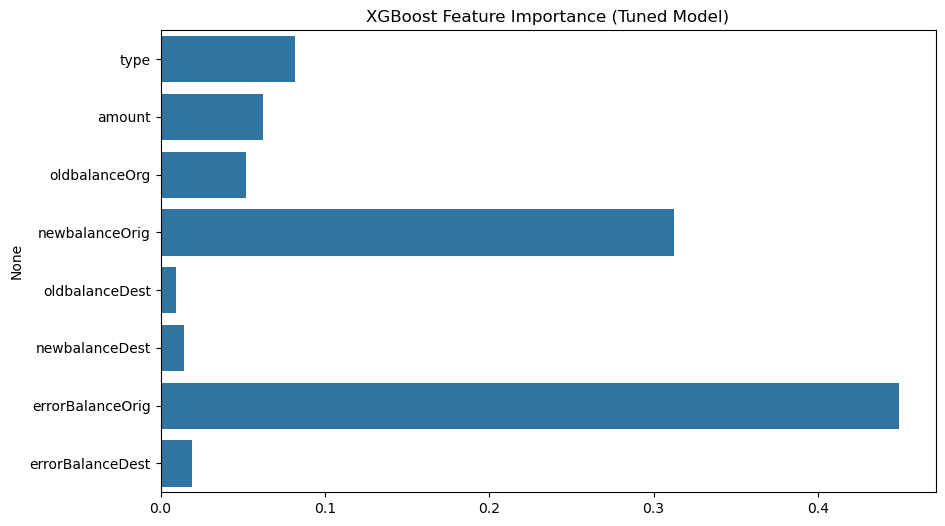

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importance = best_xgb.feature_importances_

# Create a feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=X_train.columns)
plt.title("XGBoost Feature Importance (Tuned Model)")
plt.show()


In [21]:
import pandas as pd

correlations = X_train.copy()
correlations['isFraud'] = y_train
correlation_matrix = correlations.corr()

# Print the top correlated features with fraud
print(correlation_matrix['isFraud'].sort_values(ascending=False))


isFraud             1.000000
amount              0.077127
errorBalanceDest    0.056193
type                0.020521
oldbalanceOrg       0.010282
newbalanceDest      0.000561
oldbalanceDest     -0.005771
newbalanceOrig     -0.008048
errorBalanceOrig   -0.011157
Name: isFraud, dtype: float64


# Aanpassen van de decision threshold om de precision en recall te balanceren

In [22]:
from sklearn.metrics import precision_recall_curve

# Get precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#Threshold that balances precision & recall
optimal_idx = (precision >= 0.93).argmax()  # Adjust target precision 0.93 
optimal_threshold = thresholds[optimal_idx]

# Apply new threshold
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate new classification report
print("Classification Report (Adjusted Threshold):\n", classification_report(y_test, y_pred_adjusted))

# Generate new confusion matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print("Confusion Matrix (Adjusted Threshold):\n", conf_matrix_adjusted)


Classification Report (Adjusted Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.93      0.95      0.94      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.97      0.97   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix (Adjusted Threshold):
 [[1270764     117]
 [     83    1560]]


In [24]:
import numpy as np

# Count how many predictions changed
num_changed = np.sum(y_pred_adjusted != y_pred)
print(f"Number of predictions changed: {num_changed}")


Number of predictions changed: 353


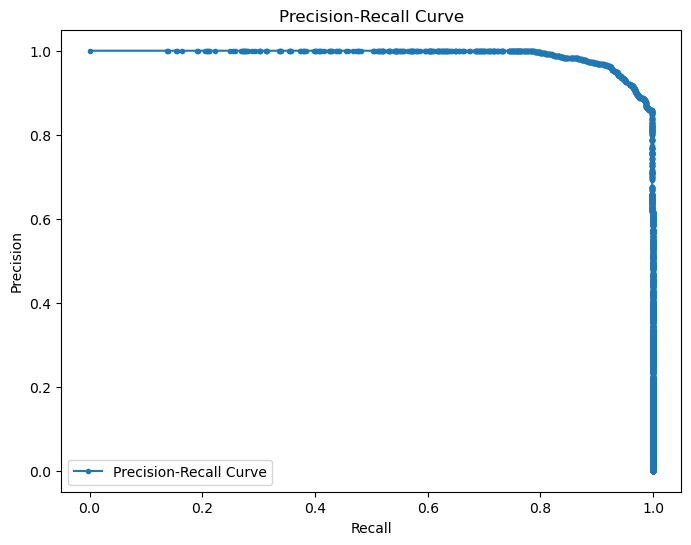

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


# Verwijder 'newbalanceOrig' om te kijken wat het effect is op het model, omdat deze  dominant was in de feature importances


In [26]:
X_train_reduced = X_train.drop(columns=['newbalanceOrig'])
X_test_reduced = X_test.drop(columns=['newbalanceOrig'])

# Train again
best_xgb.fit(X_train_reduced, y_train)
y_pred_reduced = best_xgb.predict(X_test_reduced)

# Compare accuracy
print("Test Accuracy after feature removal:", accuracy_score(y_test, y_pred_reduced))


Test Accuracy after feature removal: 0.9909109769246003


In [27]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9996


In [28]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_reduced))

# Print accuracy
accuracy = accuracy_score(y_test, y_pred_reduced)
print(f"Test Accuracy: {accuracy:.4f}")

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_reduced)
print("Confusion Matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.12      1.00      0.22      1643

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.61   1272524
weighted avg       1.00      0.99      0.99   1272524

Test Accuracy: 0.9909
Confusion Matrix:
 [[1259320   11561]
 [      5    1638]]
